# Explore `meta-kaggle` Dataset

## --- Synthetically Generated Data

We test the potential of our estimation algorithm by synthetically generated data.

In [1]:
# std library
import os
import json
from pprint import pprint
from datetime import datetime, timedelta
from typing import Sequence

# third-party
from matplotlib import pyplot as plt
import numpy as np
from numpy import typing as npt
import cmdstanpy
cmdstanpy.install_cmdstan()
from cmdstanpy import CmdStanModel

# local
import ryvkin_model
import synthetic_data as dgp

CmdStan install directory: /Users/zhuanglinsheng/.cmdstan
CmdStan version 2.36.0 already installed
Test model compilation


### 1. Model Setting

In [2]:
# Capacities & Total Innovation Uncertainty
## daily based
param_c_i = 0.15
param_c_j = 0.15
param_sigma = 1.0

# Contest prize
param_theta = 1

# Signal Precision
param_lambda = 1

# Intensity-Effort Ratio
param_r = 0.1

# Contest Time Duaration
start_time = datetime(2025, 1, 1, 0, 0, 0)
end_time = datetime(2025, 4, 1, 0, 0, 0)
contest_days = (end_time - start_time).days
contest_seconds = int((end_time - start_time).total_seconds())
contest_hours = int(contest_seconds / 3600)
contest_timegrids = np.arange(start_time, end_time, \
		timedelta(hours=1), dtype=np.datetime64)
time_unit_2f = 1 / 24

print(contest_days, contest_hours, len(contest_timegrids))

90 2160 2160


### 2. Simulations

In [3]:
time_grids, i_effort_dynamic, j_effort_dynamic, \
real_gap_dynamic, perceived_gap_dynamic, observed_gap_dynamic, \
observed_i_commits, observed_j_commits = dgp.synthetic_data_simulation(
	theta=param_theta,
	c_i=param_c_i,
	c_j=param_c_j,
	sigma=param_sigma,
	lamb=param_lambda,
	r=param_r,
	hour_arrival_ub=1,
	start_time=start_time,
	end_time=end_time,
	time_unit=timedelta(hours=1),
	time_unit_2f=time_unit_2f,
)

In [4]:
def plot_ts_events(
		time_grids: Sequence[datetime] | npt.NDArray[np.datetime64],
		ts: dict[str, Sequence | npt.NDArray],
		events: dict[str, Sequence | npt.NDArray],
		*,
		figsize=(10, 5),
		height_ratios=[3, 1],
):
	fig, (ax_main, ax_events) = plt.subplots(
		nrows=2, ncols=1, figsize=figsize, height_ratios=height_ratios
	)
	# plot time series
	for ts_key, ts_val in ts.items():
		ax_main.plot(time_grids, ts_val, label=ts_key)
	ax_main.legend()
	xrange = ax_main.get_xlim()
	# plot events
	event_height = 0.2
	ytick = 0
	yticks = []
	yticklabels = []
	for event_key, event_val in events.items():
		yticks.append(ytick)
		yticklabels.append(event_key)
		ax_events.hlines(y=ytick, xmin=xrange[0], xmax=xrange[1])
		ax_events.vlines(x=event_val, ymin=ytick - event_height, ymax=ytick + event_height)
		ytick -= 2.5 * event_height
	ax_events.set_xlim(xrange)
	ax_events.get_xaxis().set_visible(False)
	ax_events.set_yticks(yticks)
	ax_events.set_yticklabels(yticklabels)
	return fig, ax_main, ax_events

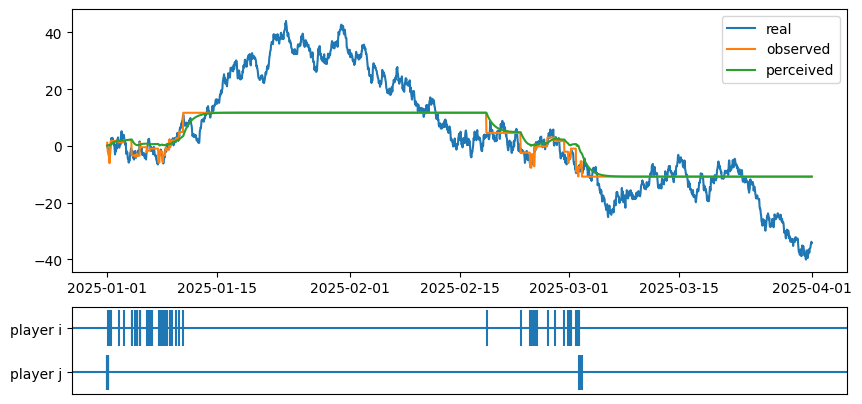

In [5]:
fig, _, _ = plot_ts_events(time_grids, {
			'real': real_gap_dynamic,
			'observed': observed_gap_dynamic,
			'perceived': perceived_gap_dynamic,
		}, {
			'player i': observed_i_commits,
			'player j': observed_j_commits,
	})

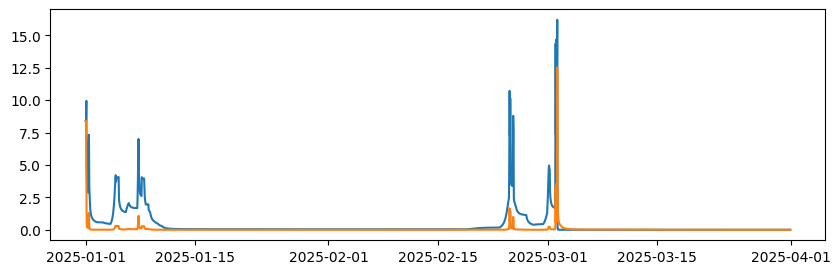

In [6]:
plt.figure(figsize=(10, 3))
plt.plot(np.array(time_grids), i_effort_dynamic)
plt.plot(np.array(time_grids), j_effort_dynamic)
plt.show()

In [7]:
# save the observed data
wd = os.getcwd()
wd_synthetic_data = os.path.join(wd, 'data.json')
roundint = lambda x: int(round(x))

with open(wd_synthetic_data, 'w') as f:
	json.dump({
		'theta': param_theta,
		'T': 1 + roundint((end_time - start_time).total_seconds() / 3600),
		'Delta2f': 1/24,
		'Ni': len(observed_i_commits),
		'Nj': len(observed_j_commits),
		'hat_t_i_loc': [1 + roundint((dt - start_time).total_seconds() / 3600) for dt in observed_i_commits],
		'hat_t_j_loc': [1 + roundint((dt - start_time).total_seconds() / 3600) for dt in observed_j_commits],
		#'hat_t_i': [(dt - start_time).total_seconds() / 3600 for dt in observed_i_commits],
		#'hat_t_j': [(dt - start_time).total_seconds() / 3600 for dt in observed_j_commits],
		'hat_y': observed_gap_dynamic.tolist(),
	}, f, indent=4)

### 3. Bayesian Inference

In [8]:
# build stan model
stan_file = os.path.join(wd, 'synthetic_data.stan')
model = CmdStanModel(stan_file=stan_file)

23:21:14 - cmdstanpy - INFO - compiling stan file /Users/zhuanglinsheng/Documents/Github/kaggle-contest-design/synthetic/synthetic_data.stan to exe file /Users/zhuanglinsheng/Documents/Github/kaggle-contest-design/synthetic/synthetic_data


KeyboardInterrupt: 

In [ ]:
# fit the model with data
fit = model.sample( \
		data=wd_synthetic_data,
		chains=1,
		iter_warmup=500,
		iter_sampling=1000,
		parallel_chains=4,
		show_console=False,
	)

23:17:08 - cmdstanpy - INFO - Requested 4 parallel_chains but only 1 required, will run all chains in parallel.
23:17:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

23:21:01 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 2 Unknown error: -2


KeyboardInterrupt: 

True Values:
- param_c_i = 0.15
- param_c_j = 0.15
- param_sigma = 1.0
- param_lambda = 1
- param_r = 0.1

Estimated:

In [ ]:
posteriors = fit.summary()
posteriors

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-2811.320000,0.193331,1.672630,1.623450,-2814.470000,-2811.060000,-2809.180000,83.5235,185.9030,1.01143
c_i,0.980316,0.087745,0.540722,0.404187,0.361165,0.854102,2.194020,12.9190,139.6830,1.11403
c_j,0.519091,0.043151,0.236664,0.215153,0.207903,0.470398,1.016260,19.0957,24.6932,1.05722
sigma,0.788149,0.029222,0.171105,0.151826,0.547283,0.758093,1.127010,18.8158,26.2455,1.05847
lambda,0.050028,0.000128,0.001046,0.001082,0.048583,0.049862,0.051957,61.8394,162.7560,1.01321
...,...,...,...,...,...,...,...,...,...,...
delta_hat_y[2156],0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
delta_hat_y[2157],0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
delta_hat_y[2158],0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
delta_hat_y[2159],0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN


In [ ]:
posterior_m_i_mean = posteriors['Mean'].iloc[6:6+2160]
posterior_m_i_mean

m_i[1]       0.022468
m_i[2]       0.022428
m_i[3]       0.022389
m_i[4]       0.022350
m_i[5]       0.022312
               ...   
m_i[2156]    0.000679
m_i[2157]    0.000448
m_i[2158]    0.000248
m_i[2159]    0.000097
m_i[2160]    0.000015
Name: Mean, Length: 2160, dtype: float64

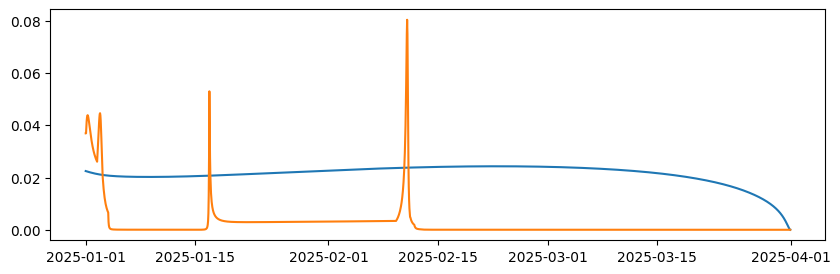

In [ ]:
# compare posterior m[1]..m[T] with real

plt.figure(figsize=(10, 3))
plt.plot(np.array(time_grids), posterior_m_i_mean)
plt.plot(np.array(time_grids), i_effort_dynamic)
plt.show()

In [ ]:
# TO DO:
